In [ ]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 17.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import torch
import pickle as pkl

#**Data Analysis**

In [ ]:
def clean(cut,s,a,d,one_hot = True):
    states_qa = [states[:-1] for states in s[:cut]]
    next_states_qa = [states[1:] for states in s[:cut]]
    actions_qa = a[:cut]
    rewards_qa = d[:cut]

    states = []
    next_states = []
    actions = []
    rewards = []

    for state in states_qa:
      states = states + state

    for next_state in next_states_qa:
      next_states = next_states + next_state

    for action in actions_qa:
      actions = actions + action

    for reward in rewards_qa:
      rewards = rewards + reward
    if one_hot :
      states = [one_hot_encode(s) for s in states]
      next_states = [one_hot_encode(s) for s in next_states]


    states = np.array(states)
    next_states = np.array(next_states)
    actions = np.array(actions)
    rewards = np.array(rewards)

    return states,next_states,actions,rewards



#**Collecting the behaviour using Q-Learning**

In [ ]:
env2 = gym.make('CartPole-v1')
num_bins =10

lower_bounds = env2.observation_space.low
upper_bounds = env2.observation_space.high
lower_bounds[1] = -3
lower_bounds[-1] = -3
upper_bounds[1] = 3
upper_bounds[-1] = 3


def one_hot_encode(state):
  bins = [
      np.linspace(lower,upper,num_bins+1)[1:]
      for (lower,upper) in zip(lower_bounds,upper_bounds)
  ]
  x = np.clip(state,lower_bounds,upper_bounds)
  idx = [np.digitize(x_i,b_i,right = True) for (x_i,b_i) in zip(x,bins)]
  one_hots = [np.eye(num_bins)[i] for i in idx]
  return np.concatenate(one_hots)


In [ ]:


class Qlearning:
  def __init__(
    self,
    num_actions : int,
    gamma : float = 0.99,
    alpha: float = 1./16,
    epsilon: float = 0.1

  ):
    self.num_actions = num_actions
    self.gamma = gamma
    self.alpha = alpha
    self.epsilon = epsilon
    self.w = np.random.uniform(-0.001,0.001,size=(4*num_bins,self.num_actions))

  def choose_eps_greedy(self,x):
    u = np.random.uniform()
    if (u <= self.epsilon):
      return np.random.choice(self.num_actions)
    qs = one_hot_encode(x).dot(self.w)
    return np.argmax(qs)

  def update(self,x,a,r,nx,d):
    next_qs = one_hot_encode(nx).dot(self.w)
    next_v = np.max(next_qs)
    target = r + self.gamma*next_v*(1-d)
    phi_x = one_hot_encode(x)
    q = phi_x.dot(self.w)[a]
    dw = (q - target)*phi_x
    self.w[:,a] -= self.alpha*dw

In [ ]:
def rollout(ql,env):
  score = []
  states = []
  actions = []
  x,_ = env.reset()
  d = False
  while not d:
    a = ql.choose_eps_greedy(x)
    states.append(x)
    actions.append(a)
    nx,r,d1,d2,_ = env.step(a)

    ql.update(x,a,r,nx,d1)
    d = d1 or d2
    x = nx

    score.append(r)
  states.append(x)
  return score,states,actions

In [ ]:
agent = Qlearning(2)
d = []
a = []
s = []
for ep in tqdm(range(500)):
    eps = rollout(agent,env2)
    d.append(eps[0])
    s.append(eps[1])
    a.append(eps[2])


100%|██████████| 500/500 [00:39<00:00, 12.51it/s]


In [ ]:
# Store the data from the QA Learning

with open("states_qa_learning.pkl","wb") as f:
  pkl.dump(s,f)

with open("actions_qa_learning.pkl","wb") as f:
  pkl.dump(a,f)

with open("score_qa_learning.pkl","wb") as f:
  pkl.dump(d,f)

#**Collecting the behaviour using Random Policy**

In [ ]:
def uniform_random(num_episodes):
  num_bins = 10
  num_actions = 2

  behaviours = []
  for episode in tqdm(range(num_episodes)):
    done = False
    rewards = []
    states = []
    actions = []

    state = env2.reset()[0]
    states.append(state)
    state = one_hot_encode(state)
    while not done:

      action = np.random.randint(0,2)
      next_state,reward,done1,done2,info = env2.step(action)
      actions.append(action)


      states.append(next_state)
      done = done1 or done2


      next_state = one_hot_encode(next_state)

      rewards.append(reward)
      state = next_state

    behaviours.append((states, actions, rewards))
  return behaviours

In [ ]:
behaviours_random = uniform_random(num_episodes=500)
d_ra = [b[-1] for b in behaviours_random]
a_ra = [b[1] for b in behaviours_random]
s_ra = [b[0] for b in behaviours_random]

100%|██████████| 500/500 [00:05<00:00, 85.34it/s] 


#**Implement the simple imitation Learning**

In [ ]:
class LR(torch.nn.Module):
    def __init__(self, input, output):
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(input, output)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        out = self.sigmoid(x)
        return out


In [ ]:
def rewards_LR(env,model):
  score = 0
  x,_ = env.reset()
  d = False
  while not d:
    proba = model(torch.Tensor(one_hot_encode(x)))
    a = int((proba > 0.5))
    nx,r,d1,d2,_ = env.step(a)
    d = d1 or d2
    x = nx
    score += r
  return score



#**Implement Fitted Q Learning**

In [ ]:
class Fitted_Q_learning():
  def __init__(self,steps_phi,gamma,alpha):
    self.steps_phi = steps_phi
    self.num_actions = 2
    self.bins = 10
    self.gamma = gamma
    self.alpha = alpha
    self.phi = np.random.uniform(-0.001,0.001,size=(self.bins*4,self.num_actions))

  def loss(self,S,A,NS,R,y):
    L = 0
    for i in range(len(R)):
      L = L + (self.phi[:,A[i]].dot(S[i]) - y[i])**2
    return L/(2*len(R))

  def forward(self,S,A,NS,R):
    y = np.zeros(R.shape)
    for i in range(len(R)) :
      q_ns_0 = self.phi[:,0].dot(NS[i])
      q_ns_1 = self.phi[:,1].dot(NS[i])
      y[i] = R[i] + self.gamma* max(q_ns_0,q_ns_1)
    # print(max(y))    #REDO r = reward ?

    for epoch in range(self.steps_phi):
      self.phi[:,0] += self.alpha* (y[i] - self.phi[:,0] ) # REDO and do we use 10**4 ?
      self.phi[:,1] += self.alpha* (y[i] - self.phi[:,1] )

    print(self.loss(S,A,NS,R,y))
    return self.loss(S,A,NS,R,y)




In [ ]:
def rewards_fitted(env,mdl):
  score = 0
  x,_ = env.reset()
  d = False
  while not d:
    qs = one_hot_encode(x).dot(mdl.phi)
    a =  np.argmax(qs)
    nx,r,d1,d2,_ = env.step(a)
    d = d1 or d2
    x = nx
    score += r
  return score

#**Implement MLP**

In [ ]:
class MLP_Q_fitted():
  def __init__(self,input,h1,h2,output,gamma):
    self.gamma = gamma
    self.layers = torch.nn.Sequential(
        torch.nn.Linear(input,h1),
        torch.nn.ReLU(),
        torch.nn.Linear(h1,h2),
        torch.nn.ReLU(),
        torch.nn.Linear(h2,output),


    )

  def loss(self,Q,y):
    return 0.5*torch.mean((Q - y)**2)


  def forward(self,S,A,NS,R,optim):

    S = torch.tensor(S, dtype=torch.float32)
    A = torch.tensor(A, dtype=torch.long).view(-1, 1)
    NS = torch.tensor(NS, dtype=torch.float32)
    R = torch.tensor(R, dtype=torch.float32).view(-1, 1)

    Q = self.layers(S)

    Q = Q.gather(1,A)

    #calculate the target

    with torch.no_grad():
      next_Q = self.layers(NS)
      max_next_Q = next_Q.max(dim=1)[0].view(-1, 1)
      target = R + self.gamma*max_next_Q

    loss = self.loss(Q,target.squeeze())

    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss.item()




In [ ]:
def rewards_MLP(env,mdl,one_hot = False):
  score = 0
  x,_ = env.reset()
  d = False
  while not d:
    x = torch.Tensor(one_hot_encode(x))
    qs = mdl.layers(x)
    a =  int(torch.argmax(qs))
    nx,r,d1,d2,_ = env.step(a)
    d = d1 or d2
    x = nx
    score += r
  return score

# **Data size of 500 episodes**

In [ ]:
#getting the data in shape

S_1,NS_1,A_1,R_1 = clean(250,s_ra,a_ra,d_ra)
S_2,NS_2,A_2,R_2 = clean(250,s,a,d)

S_train = list(S_1) + list(S_2)
NS_train = list(NS_1) + list(NS_2)
A_train = list(A_1) + list(A_2)
R_train = list(R_1) + list(R_2)

ind = list(range(len(S_train)))
np.random.shuffle(ind)

S_train = np.array([S_train[i] for i in ind])
NS_train = np.array([NS_train[i] for i in ind])
A_train = np.array([A_train[i] for i in ind])
R_train = np.array([R_train[i] for i in ind])




In [ ]:
K = 15
np.random.seed(np.random.randint(0,15))
ftq7 = Fitted_Q_learning(10,gamma = 0.99, alpha = 0.005)
losses = []
for epoch in tqdm(range(K)):
  losses.append(ftq7.forward(S_train,A_train,NS_train,R_train))


  0%|          | 0/15 [00:00<?, ?it/s]

0.3240781347202679


 13%|█▎        | 2/15 [00:01<00:08,  1.55it/s]

0.3001845543273457


 20%|██        | 3/15 [00:01<00:05,  2.11it/s]

0.27395929760442195
0.24541284194474874


 33%|███▎      | 5/15 [00:02<00:03,  3.33it/s]

0.21466522440400662
0.18199542558116455


 47%|████▋     | 7/15 [00:02<00:01,  4.23it/s]

0.14790830657057275
0.11322486902268528


 60%|██████    | 9/15 [00:02<00:01,  4.71it/s]

0.0792034458082897
0.04770184427654898


 73%|███████▎  | 11/15 [00:03<00:00,  4.95it/s]

0.021393635701104696


 80%|████████  | 12/15 [00:03<00:00,  4.80it/s]

0.004055949321467904


 87%|████████▋ | 13/15 [00:03<00:00,  4.89it/s]

0.0009515969523988939
0.019335530249704008


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

0.06912504934713806


In [ ]:
scores = []
for run in range(100):
  score = rewards_fitted(env2,ftq7)
  scores.append(score)
mean_500_mixed_005 = np.mean(scores)
std_500_mixed_005 = np.std(scores)/np.square(len(scores))
print(np.mean(scores))
print(np.std(scores))

39.38
47.21033361458061


In [ ]:
#Training the Model
model = LR(40,1)

#Training the LR model
perc_split = 0.5
K = 100

X = torch.Tensor(S_train)
Y = torch.Tensor(A_train)
#Spliting between train and test
split = int(perc_split*len(X))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

alpha = 0.05
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)

Loss = []

for epoch in range(K):
  optimizer.zero_grad()
  Y_pred = model(X_train)
  # get loss for the predicted output
  loss = criterion(Y_pred, Y_train.reshape(-1,1))
  loss.backward()
  optimizer.step()
  Loss.append(loss.item())

Y_predict = (model(X_test) >= 0.5).float()
Acc = (Y_predict == Y_test.reshape(-1,1))
torch.sum(Acc)/len(Acc)

tensor(0.7878)

195.42
38.755691194971604


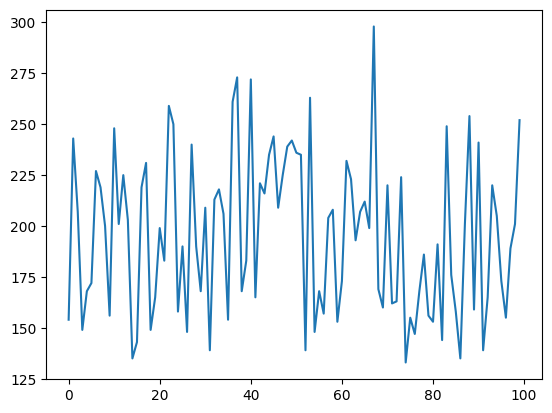

In [ ]:
scores = []
for run in range(100):
  score = rewards_LR(env2,model)
  scores.append(score)
plt.plot(scores)
mean_500_mixed_005_LR = np.mean(scores)
std_500_mixde_005_LR = np.std(scores)/np.square(len(scores))
print(np.mean(scores))
print(np.std(scores))

In [ ]:
#Training the MLP Model

MLP = MLP_Q_fitted(40,20,20,2,gamma = 0.9)

optimizer = torch.optim.SGD(MLP.layers.parameters(), lr=0.1)

losses = []
K = 50
for run in tqdm(range(50)):
  loss= MLP.forward(S_train,A_train,NS_train,R_train,optimizer)
  losses.append(loss)
  print(loss)



  2%|▏         | 1/50 [00:02<01:47,  2.19s/it]

0.6849259734153748


  4%|▍         | 2/50 [00:04<01:40,  2.10s/it]

0.6602683663368225


  6%|▌         | 3/50 [00:06<01:44,  2.22s/it]

0.6378902792930603


  8%|▊         | 4/50 [00:09<01:47,  2.33s/it]

0.6171072721481323


 10%|█         | 5/50 [00:11<01:39,  2.22s/it]

0.5971618890762329


 12%|█▏        | 6/50 [00:13<01:34,  2.15s/it]

0.5778554081916809


 14%|█▍        | 7/50 [00:15<01:30,  2.11s/it]

0.5590255856513977


 16%|█▌        | 8/50 [00:17<01:27,  2.08s/it]

0.540386974811554


 18%|█▊        | 9/50 [00:19<01:26,  2.10s/it]

0.5214362740516663


 20%|██        | 10/50 [00:21<01:29,  2.23s/it]

0.5015376806259155


 22%|██▏       | 11/50 [00:23<01:24,  2.16s/it]

0.48059526085853577


 24%|██▍       | 12/50 [00:25<01:20,  2.12s/it]

0.45858579874038696


 26%|██▌       | 13/50 [00:27<01:17,  2.09s/it]

0.4352501928806305


 28%|██▊       | 14/50 [00:29<01:14,  2.07s/it]

0.4102378487586975


 30%|███       | 15/50 [00:32<01:13,  2.10s/it]

0.38321569561958313


 32%|███▏      | 16/50 [00:34<01:16,  2.24s/it]

0.35523250699043274


 34%|███▍      | 17/50 [00:36<01:11,  2.17s/it]

0.32938840985298157


 36%|███▌      | 18/50 [00:38<01:08,  2.14s/it]

0.31279388070106506


 38%|███▊      | 19/50 [00:40<01:05,  2.11s/it]

0.30422019958496094


 40%|████      | 20/50 [00:42<01:02,  2.08s/it]

0.30087754130363464


 42%|████▏     | 21/50 [00:44<01:01,  2.12s/it]

0.30426907539367676


 44%|████▍     | 22/50 [00:47<01:02,  2.23s/it]

0.3176894187927246


 46%|████▌     | 23/50 [00:49<00:58,  2.16s/it]

0.3452112376689911


 48%|████▊     | 24/50 [00:51<00:55,  2.12s/it]

0.3864139914512634


 50%|█████     | 25/50 [00:53<00:52,  2.09s/it]

0.43094703555107117


 52%|█████▏    | 26/50 [00:55<00:49,  2.07s/it]

0.45877203345298767


 54%|█████▍    | 27/50 [00:57<00:48,  2.10s/it]

0.4526219069957733


 56%|█████▌    | 28/50 [01:00<00:50,  2.30s/it]

0.4140181243419647


 58%|█████▊    | 29/50 [01:02<00:47,  2.26s/it]

0.359624981880188


 60%|██████    | 30/50 [01:05<00:51,  2.57s/it]

0.3050002455711365


 62%|██████▏   | 31/50 [01:09<00:54,  2.88s/it]

0.25745660066604614


 64%|██████▍   | 32/50 [01:13<00:56,  3.16s/it]

0.21908001601696014


 66%|██████▌   | 33/50 [01:15<00:48,  2.82s/it]

0.18870089948177338


 68%|██████▊   | 34/50 [01:17<00:41,  2.58s/it]

0.16474056243896484


 70%|███████   | 35/50 [01:19<00:36,  2.41s/it]

0.14576421678066254


 72%|███████▏  | 36/50 [01:21<00:32,  2.30s/it]

0.13065609335899353


 74%|███████▍  | 37/50 [01:23<00:29,  2.27s/it]

0.11840210855007172


 76%|███████▌  | 38/50 [01:26<00:28,  2.33s/it]

0.10817470401525497


 78%|███████▊  | 39/50 [01:28<00:24,  2.24s/it]

0.09942172467708588


 80%|████████  | 40/50 [01:30<00:21,  2.17s/it]

0.09178764373064041


 82%|████████▏ | 41/50 [01:32<00:19,  2.13s/it]

0.08501189947128296


 84%|████████▍ | 42/50 [01:34<00:16,  2.10s/it]

0.07891693711280823


 86%|████████▌ | 43/50 [01:36<00:14,  2.13s/it]

0.0733967050909996


 88%|████████▊ | 44/50 [01:38<00:13,  2.24s/it]

0.06836996972560883


 90%|█████████ | 45/50 [01:40<00:10,  2.17s/it]

0.06376843899488449


 92%|█████████▏| 46/50 [01:42<00:08,  2.13s/it]

0.05953503027558327


 94%|█████████▍| 47/50 [01:44<00:06,  2.09s/it]

0.05562692880630493


 96%|█████████▌| 48/50 [01:47<00:04,  2.08s/it]

0.05201057717204094


 98%|█████████▊| 49/50 [01:49<00:02,  2.12s/it]

0.04865863174200058


100%|██████████| 50/50 [01:51<00:00,  2.23s/it]

0.04554898664355278


In [ ]:
scores = []
for run in range(100):
  score = rewards_MLP(env2,MLP,one_hot = True)
  scores.append(score)
mean_500_mixed_005_MLP = np.mean(scores)
std_500_mixed_005_MLP = np.std(scores)/np.square(len(scores))
print(np.mean(scores))
print(np.std(scores)/np.square(len(scores)))

161.52
0.006282968725053468


#The plot of the 500 size dataset

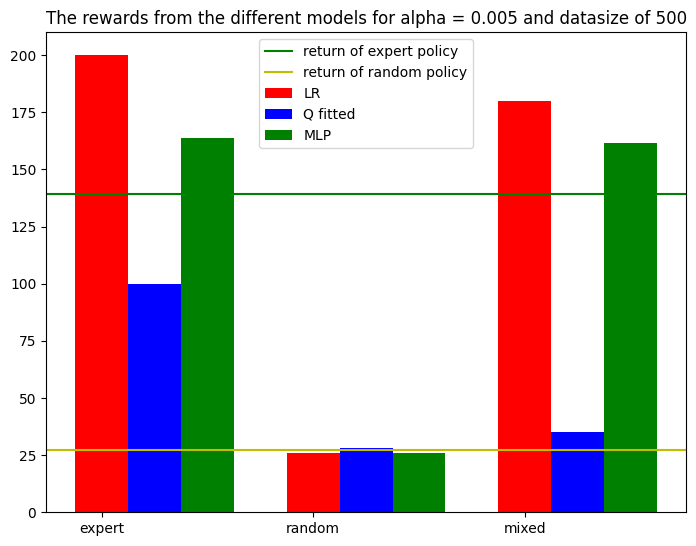

In [ ]:
L_R = [mean_500_expert_005_LR,mean_500_random_005_LR,mean_500_mixed_005_LR]
fitted = [mean_500_expert_005,mean_500_random_005,mean_500_mixed_005]
MLP = [mean_500_expert_005_MLP,mean_500_random_005_MLP,mean_500_mixed_005_MLP]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0, L_R, color ='r',label = "LR",width = 0.25)
ax.bar(X + 0.25, fitted, color ='b',label = "Q fitted",width = 0.25)
ax.bar(X + 0.5, MLP, color ='g',label = "MLP",width = 0.25)

ax.axhline(y = 139.28,color ='g',label = 'return of expert policy')
ax.axhline(y = 27.24,color ='y',label = 'return of random policy')
plt.xticks(X,["expert", "random","mixed"])
plt.title("The rewards from the different models for alpha = 0.005 and datasize of 500")
ax.legend()

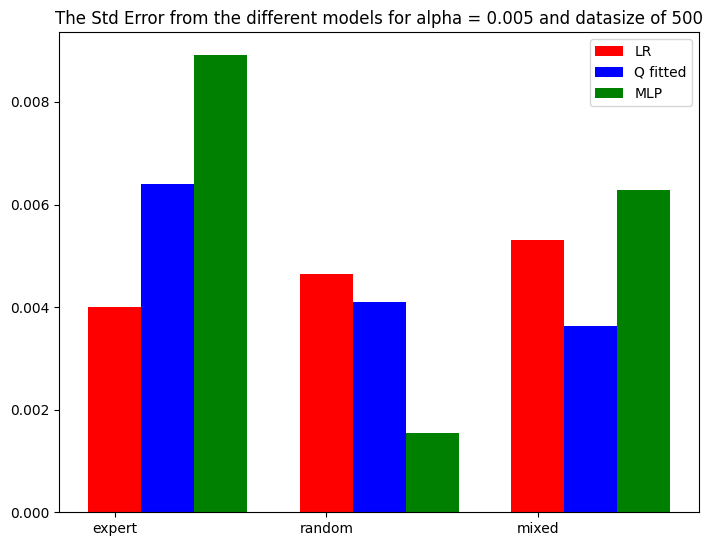

In [ ]:
L_R = [std_500_expert_005_LR,std_500_random_005_LR,std_500_mixed_005_LR]
fitted =  [std_500_expert_005,std_500_random_005,std_500_mixed_005]
MLP = [std_500_expert_005_MLP,std_500_random_005_MLP,std_500_mixed_005_MLP]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0, L_R, color ='r',label = "LR",width = 0.25)
ax.bar(X + 0.25, fitted, color ='b',label = "Q fitted",width = 0.25)
ax.bar(X + 0.5, MLP, color ='g',label = "MLP",width = 0.25)


plt.xticks(X,["expert", "random","mixed"])
plt.title("The Std Error from the different models for alpha = 0.005 and datasize of 500")
ax.legend()

#**Datasize of 250**

In [ ]:
# S_1,NS_1,A_1,R_1 = clean(125,s_ra,a_ra,d_ra)
# S_2,NS_2,A_2,R_2 = clean(125,s,a,d)

# S_train = list(S_1) + list(S_2)
# NS_train = list(NS_1) + list(NS_2)
# A_train = list(A_1) + list(A_2)
# R_train = list(R_1) + list(R_2)

# ind = list(range(len(S_train)))
# np.random.shuffle(ind)

# S_train = np.array([S_train[i] for i in ind])
# NS_train = np.array([NS_train[i] for i in ind])
# A_train = np.array([A_train[i] for i in ind])
# R_train = np.array([R_train[i] for i in ind])


S_train,NS_train,A_train,R_train = clean(250,s,a,d)

# S_train,NS_train,A_train,R_train = clean(250,s_ra,a_ra,d_ra)


NameError: ignored

In [ ]:
# Q fitted Training
K = 13
np.random.seed(np.random.randint(0,15))
ftq = Fitted_Q_learning(10,gamma = 0.99, alpha = 0.005)
losses = []
for epoch in tqdm(range(K)):
  losses.append(ftq.forward(S_train,A_train,NS_train,R_train))


 15%|█▌        | 2/13 [00:00<00:00, 11.15it/s]

0.32396973568184223
0.30007399362360776
0.27384644470727026


 31%|███       | 4/13 [00:00<00:00, 10.58it/s]

0.24529782190765062
0.21454853118597814
0.18187807606663267


 62%|██████▏   | 8/13 [00:00<00:00, 10.83it/s]

0.14779204870000084
0.11311246172751183
0.07909903406811987


 77%|███████▋  | 10/13 [00:00<00:00, 10.66it/s]

0.047611460004927886
0.021325864869835207
0.004022818474188762


100%|██████████| 13/13 [00:01<00:00, 10.78it/s]

0.0009697489817106158


In [ ]:
scores = []
for run in range(100):
  score = rewards_fitted(env2,ftq)
  scores.append(score)
mean_250_mixed_005 = np.mean(scores)
std_250_mixed_005 = np.std(scores)/np.square(len(scores))
print(np.mean(scores))
print(np.std(scores))

36.38
44.873105531041645


In [ ]:
#Training the Model
model = LR(40,1)

#Training the LR model
perc_split = 0.5
K = 100

X = torch.Tensor(S_train)
Y = torch.Tensor(A_train)
#Spliting between train and test
split = int(perc_split*len(X))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

alpha = 0.05
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)

Loss = []

for epoch in range(K):
  optimizer.zero_grad()
  Y_pred = model(X_train)
  # get loss for the predicted output
  loss = criterion(Y_pred, Y_train.reshape(-1,1))
  loss.backward()
  optimizer.step()
  Loss.append(loss.item())

Y_predict = (model(X_test) >= 0.5).float()
Acc = (Y_predict == Y_test.reshape(-1,1))
torch.sum(Acc)/len(Acc)

tensor(0.7611)

In [ ]:
scores = []
for run in range(100):
  score = rewards_LR(env2,model)
  scores.append(score)
mean_250_mixed_005_LR = np.mean(scores)
std_250_mixed_005_LR = np.std(scores)/np.square(len(scores))
print(np.mean(scores))
print(np.std(scores))

196.18
45.131891163566365


In [ ]:
## Training the MLP Model

MLP = MLP_Q_fitted(40,20,20,2,gamma = 0.9)

optimizer = torch.optim.SGD(MLP.layers.parameters(), lr=0.05)

losses = []
K = 100
for run in tqdm(range(K)):
  loss= MLP.forward(S_train,A_train,NS_train,R_train,optimizer)
  losses.append(loss)
  print(loss)

  2%|▏         | 2/100 [00:00<00:13,  7.38it/s]

0.546254575252533
0.542069673538208


  3%|▎         | 3/100 [00:00<00:14,  6.61it/s]

0.5380043983459473


  4%|▍         | 4/100 [00:00<00:17,  5.39it/s]

0.5340437889099121


  5%|▌         | 5/100 [00:00<00:19,  4.95it/s]

0.5302029848098755


  6%|▌         | 6/100 [00:01<00:19,  4.73it/s]

0.5264533162117004


  7%|▋         | 7/100 [00:01<00:20,  4.55it/s]

0.5227382183074951


  8%|▊         | 8/100 [00:01<00:20,  4.46it/s]

0.5190514326095581


  9%|▉         | 9/100 [00:01<00:20,  4.41it/s]

0.5153985619544983


 10%|█         | 10/100 [00:02<00:20,  4.41it/s]

0.5118036866188049


 11%|█         | 11/100 [00:02<00:20,  4.37it/s]

0.5083026885986328


 12%|█▏        | 12/100 [00:02<00:20,  4.34it/s]

0.504814863204956


 13%|█▎        | 13/100 [00:02<00:20,  4.33it/s]

0.5013346672058105


 14%|█▍        | 14/100 [00:02<00:19,  4.34it/s]

0.497784823179245


 15%|█▌        | 15/100 [00:03<00:19,  4.29it/s]

0.49420300126075745


 16%|█▌        | 16/100 [00:03<00:19,  4.29it/s]

0.4906006157398224


 17%|█▋        | 17/100 [00:03<00:19,  4.33it/s]

0.4870006740093231


 18%|█▊        | 18/100 [00:03<00:18,  4.32it/s]

0.48328953981399536


 19%|█▉        | 19/100 [00:04<00:18,  4.28it/s]

0.47944241762161255


 20%|██        | 20/100 [00:04<00:18,  4.24it/s]

0.4754772484302521


 21%|██        | 21/100 [00:04<00:18,  4.27it/s]

0.47136980295181274


 22%|██▏       | 22/100 [00:04<00:18,  4.30it/s]

0.46708226203918457


 23%|██▎       | 23/100 [00:05<00:17,  4.34it/s]

0.46262386441230774


 24%|██▍       | 24/100 [00:05<00:17,  4.30it/s]

0.4579538404941559


 25%|██▌       | 25/100 [00:05<00:17,  4.33it/s]

0.4530613422393799


 26%|██▌       | 26/100 [00:05<00:18,  4.06it/s]

0.44790470600128174


 27%|██▋       | 27/100 [00:06<00:19,  3.83it/s]

0.44247132539749146


 28%|██▊       | 28/100 [00:06<00:19,  3.62it/s]

0.4366896450519562


 29%|██▉       | 29/100 [00:06<00:20,  3.53it/s]

0.43051043152809143


 30%|███       | 30/100 [00:07<00:21,  3.31it/s]

0.423906147480011


 31%|███       | 31/100 [00:07<00:30,  2.30it/s]

0.4167787730693817


 32%|███▏      | 32/100 [00:08<00:28,  2.36it/s]

0.4090842008590698


 33%|███▎      | 33/100 [00:08<00:26,  2.56it/s]

0.40075013041496277


 34%|███▍      | 34/100 [00:08<00:23,  2.86it/s]

0.3917577564716339


 35%|███▌      | 35/100 [00:09<00:20,  3.17it/s]

0.38203826546669006


 36%|███▌      | 36/100 [00:09<00:20,  3.18it/s]

0.3715613782405853


 37%|███▋      | 37/100 [00:09<00:22,  2.84it/s]

0.36029550433158875


 38%|███▊      | 38/100 [00:10<00:20,  3.03it/s]

0.348241925239563


 39%|███▉      | 39/100 [00:10<00:18,  3.31it/s]

0.3354722261428833


 40%|████      | 40/100 [00:10<00:17,  3.45it/s]

0.3221094310283661


 41%|████      | 41/100 [00:10<00:16,  3.65it/s]

0.30854544043540955


 42%|████▏     | 42/100 [00:11<00:16,  3.61it/s]

0.29516831040382385


 43%|████▎     | 43/100 [00:11<00:16,  3.41it/s]

0.2822951376438141


 44%|████▍     | 44/100 [00:11<00:17,  3.12it/s]

0.27086204290390015


 45%|████▌     | 45/100 [00:12<00:20,  2.64it/s]

0.262131929397583


 46%|████▌     | 46/100 [00:12<00:24,  2.19it/s]

0.25716903805732727


 47%|████▋     | 47/100 [00:13<00:22,  2.31it/s]

0.2552616596221924


 48%|████▊     | 48/100 [00:13<00:21,  2.41it/s]

0.2561219036579132


 49%|████▉     | 49/100 [00:14<00:19,  2.63it/s]

0.259735107421875


 50%|█████     | 50/100 [00:14<00:17,  2.91it/s]

0.26554176211357117


 51%|█████     | 51/100 [00:14<00:15,  3.18it/s]

0.2730309069156647


 52%|█████▏    | 52/100 [00:14<00:14,  3.42it/s]

0.2804957330226898


 53%|█████▎    | 53/100 [00:14<00:13,  3.60it/s]

0.28643500804901123


 54%|█████▍    | 54/100 [00:15<00:12,  3.74it/s]

0.28998681902885437


 55%|█████▌    | 55/100 [00:15<00:13,  3.33it/s]

0.2904752194881439


 56%|█████▌    | 56/100 [00:15<00:13,  3.19it/s]

0.2879023849964142


 57%|█████▋    | 57/100 [00:16<00:13,  3.16it/s]

0.2824598252773285


 58%|█████▊    | 58/100 [00:16<00:14,  2.90it/s]

0.27462220191955566


 59%|█████▉    | 59/100 [00:17<00:14,  2.87it/s]

0.2650231719017029


 60%|██████    | 60/100 [00:17<00:13,  2.95it/s]

0.25435373187065125


 61%|██████    | 61/100 [00:17<00:12,  3.25it/s]

0.24324916303157806


 62%|██████▏   | 62/100 [00:17<00:10,  3.47it/s]

0.23205406963825226


 63%|██████▎   | 63/100 [00:18<00:10,  3.67it/s]

0.22108468413352966


 64%|██████▍   | 64/100 [00:18<00:09,  3.82it/s]

0.21052540838718414


 65%|██████▌   | 65/100 [00:18<00:08,  3.93it/s]

0.2004481703042984


 66%|██████▌   | 66/100 [00:18<00:08,  3.82it/s]

0.19092689454555511


 67%|██████▋   | 67/100 [00:19<00:09,  3.65it/s]

0.18200169503688812


 68%|██████▊   | 68/100 [00:19<00:09,  3.55it/s]

0.17361272871494293


 69%|██████▉   | 69/100 [00:19<00:08,  3.49it/s]

0.16577622294425964


 70%|███████   | 70/100 [00:20<00:08,  3.46it/s]

0.1584712117910385


 71%|███████   | 71/100 [00:20<00:08,  3.44it/s]

0.15166665613651276


 72%|███████▏  | 72/100 [00:20<00:08,  3.42it/s]

0.14533159136772156


 73%|███████▎  | 73/100 [00:20<00:08,  3.36it/s]

0.13941387832164764


 74%|███████▍  | 74/100 [00:21<00:07,  3.38it/s]

0.13389447331428528


 75%|███████▌  | 75/100 [00:21<00:07,  3.40it/s]

0.12873125076293945


 76%|███████▌  | 76/100 [00:21<00:06,  3.53it/s]

0.12388424575328827


 77%|███████▋  | 77/100 [00:22<00:06,  3.70it/s]

0.1193387433886528


 78%|███████▊  | 78/100 [00:22<00:05,  3.85it/s]

0.11506827920675278


 79%|███████▉  | 79/100 [00:22<00:05,  3.97it/s]

0.11104986071586609


 80%|████████  | 80/100 [00:22<00:04,  4.07it/s]

0.10726012289524078


 81%|████████  | 81/100 [00:22<00:04,  4.07it/s]

0.10368034988641739


 82%|████████▏ | 82/100 [00:23<00:04,  4.15it/s]

0.10029290616512299


 83%|████████▎ | 83/100 [00:23<00:04,  4.19it/s]

0.09707987308502197


 84%|████████▍ | 84/100 [00:23<00:03,  4.22it/s]

0.09403096139431


 85%|████████▌ | 85/100 [00:23<00:03,  4.20it/s]

0.09113495796918869


 86%|████████▌ | 86/100 [00:24<00:03,  4.26it/s]

0.08838005363941193


 87%|████████▋ | 87/100 [00:24<00:03,  4.17it/s]

0.08575572818517685


 88%|████████▊ | 88/100 [00:24<00:02,  4.22it/s]

0.08325168490409851


 89%|████████▉ | 89/100 [00:24<00:02,  4.24it/s]

0.08086107671260834


 90%|█████████ | 90/100 [00:25<00:02,  4.22it/s]

0.0785766988992691


 91%|█████████ | 91/100 [00:25<00:02,  4.22it/s]

0.07639211416244507


 92%|█████████▏| 92/100 [00:25<00:01,  4.21it/s]

0.07430095970630646


 93%|█████████▎| 93/100 [00:25<00:01,  4.20it/s]

0.07229761779308319


 94%|█████████▍| 94/100 [00:26<00:01,  4.22it/s]

0.07037974148988724


 95%|█████████▌| 95/100 [00:26<00:01,  4.24it/s]

0.06853946298360825


 96%|█████████▌| 96/100 [00:26<00:00,  4.22it/s]

0.06677141785621643


 97%|█████████▋| 97/100 [00:26<00:00,  4.23it/s]

0.06507167220115662


 98%|█████████▊| 98/100 [00:26<00:00,  4.23it/s]

0.06343688815832138


 99%|█████████▉| 99/100 [00:27<00:00,  4.25it/s]

0.061863623559474945


100%|██████████| 100/100 [00:27<00:00,  3.64it/s]

0.06034977361559868


In [ ]:
scores = []
for run in range(100):
  score = rewards_MLP(env2,MLP,one_hot = True)
  scores.append(score)
mean_250_mixed_005_MLP = np.mean(scores)
std_250_mixed_005_MLP = np.std(scores)/np.square(len(scores))
print(np.mean(scores))
print(np.std(scores)/np.square(len(scores)))

148.88
0.0041226030611738506


#Plot of the 250 dataset size

Text(0.5, 1.0, 'The rewards from the different models for alpha = 0.005 and datasize of size 250')

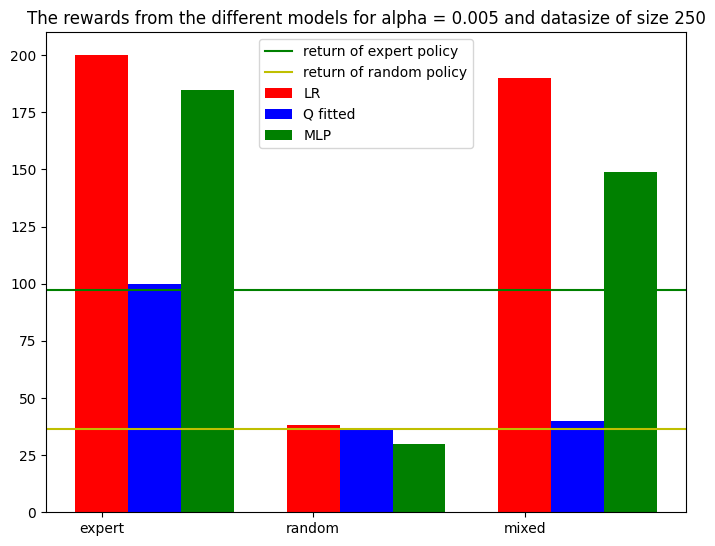

In [ ]:
L_R = [mean_250_expert_005_LR,mean_250_random_005_LR,mean_250_mixed_005_LR]
fitted = [mean_250_expert_005,mean_250_random_005,mean_250_mixed_005]
MLP = [mean_250_expert_005_MLP,mean_250_random_005_MLP,mean_250_mixed_005_MLP]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0, L_R, color ='r',label = "LR",width = 0.25)
ax.bar(X + 0.25, fitted, color ='b',label = "Q fitted",width = 0.25)
ax.bar(X + 0.5, MLP, color ='g',label = "MLP",width = 0.25)

ax.axhline(y = 97.28,color ='g',label = 'return of expert policy')
ax.axhline(y = 36.24,color ='y',label = 'return of random policy')
plt.legend()
plt.xticks(X,["expert", "random","mixed"])
plt.title("The rewards from the different models for alpha = 0.005 and datasize of size 250")


Text(0.5, 1.0, 'The Standard error reward from the different models for alpha = 0.005 and datasize of size of 250')

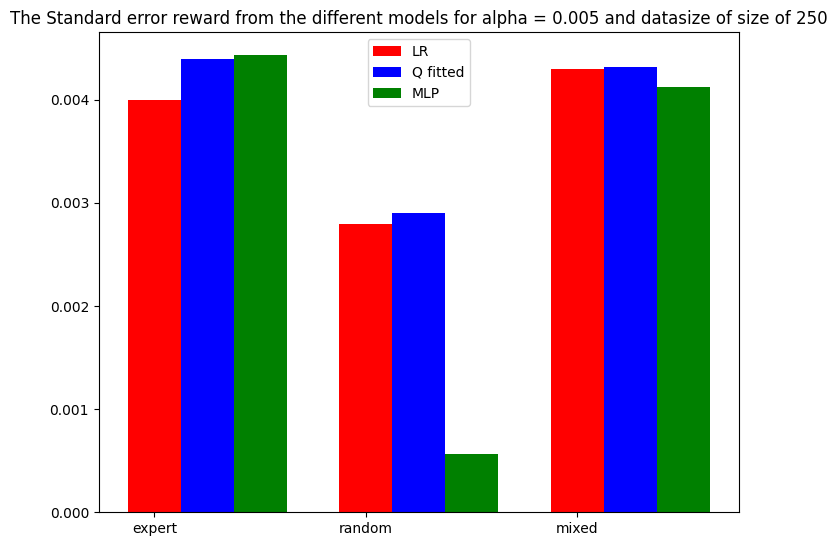

In [ ]:
L_R = [std_250_expert_005_LR,std_250_random_005_LR,std_250_mixed_005_LR]
fitted = [std_250_expert_005,std_250_random_005,std_250_mixed_005]
MLP = [std_250_expert_005_MLP,std_250_random_005_MLP,std_250_mixed_005_MLP]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0, L_R, color ='r',label = "LR",width = 0.25)
ax.bar(X + 0.25, fitted, color ='b',label = "Q fitted",width = 0.25)
ax.bar(X + 0.5, MLP, color ='g',label = "MLP",width = 0.25)
# ax.axhline(y = 139.28,color ='g',label = 'return of expert policy')
# ax.axhline(y = 27.24,color ='y',label = 'return of random policy')
plt.xticks(X,["expert", "random","mixed"])
plt.legend()
plt.title("The Standard error reward from the different models for alpha = 0.005 and datasize of size of 250")

# **Dataset of size 100**

In [ ]:
# S_1,NS_1,A_1,R_1 = clean(50,s_ra,a_ra,d_ra)
# S_2,NS_2,A_2,R_2 = clean(50,s,a,d)

# S_train = list(S_1) + list(S_2)
# NS_train = list(NS_1) + list(NS_2)
# A_train = list(A_1) + list(A_2)
# R_train = list(R_1) + list(R_2)

# ind = list(range(len(S_train)))
# np.random.shuffle(ind)

# S_train = np.array([S_train[i] for i in ind])
# NS_train = np.array([NS_train[i] for i in ind])
# A_train = np.array([A_train[i] for i in ind])
# R_train = np.array([R_train[i] for i in ind])

# Expert data
#S_train,NS_train,A_train,R_train = clean(100,s,a,d)

S_train,NS_train,A_train,R_train = clean(100,s_ra,a_ra,d_ra)


In [ ]:
# Q fitted Training
K = 12
np.random.seed(np.random.randint(0,15))
ftq = Fitted_Q_learning(100,gamma = 0.99, alpha = 0.005)
losses = []
for epoch in tqdm(range(K)):
  losses.append(ftq.forward(S_train,A_train,NS_train,R_train))

 50%|█████     | 6/12 [00:00<00:00, 50.16it/s]

0.166402044576203
2.959699877722277
20.832834391811044
115.06453764238555
579.8687265061437
2810.7740924237983
13390.955232140477
63297.87655359956
298130.2741162694
1401862.312978779
6586792.710296612


100%|██████████| 12/12 [00:00<00:00, 49.12it/s]

30937852.13051162


In [ ]:
scores = []
for run in (range(100)):
  score = rewards_fitted(env2,ftq)
  scores.append(score)
mean_100_mixed_005 = np.mean(scores)
std_100_mixed_005 = np.std(scores)/np.square(len(scores))
print(np.mean(scores))
print(np.std(scores))

34.64
42.17736833895637


In [ ]:
#Training the Model
model = LR(40,1)

#Training the LR model
perc_split = 0.5
K = 1000

X = torch.Tensor(S_train)
Y = torch.Tensor(A_train)
#Spliting between train and test
split = int(perc_split*len(X))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

alpha = 0.05
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)

Loss = []

for epoch in range(K):
  optimizer.zero_grad()
  Y_pred = model(X_train)
  # get loss for the predicted output
  loss = criterion(Y_pred, Y_train.reshape(-1,1))
  loss.backward()
  optimizer.step()
  Loss.append(loss.item())

Y_predict = (model(X_test) >= 0.5).float()
Acc = (Y_predict == Y_test.reshape(-1,1))
torch.sum(Acc)/len(Acc)

tensor(0.5221)

In [ ]:
scores = []
for run in range(100):
  score = rewards_LR(env2,model)
  scores.append(score)
mean_100_random_005_LR = np.mean(scores)
std_100_random_005_LR = np.std(scores)/np.square(len(scores))
print(np.mean(scores))
print(np.std(scores))

31.43
15.315518273959912


In [ ]:
# S_1,NS_1,A_1,R_1 = clean(50,s_ra,a_ra,d_ra,one_hot = True)
# S_2,NS_2,A_2,R_2 = clean(50,s,a,d,one_hot = True)

# S_train = list(S_1) + list(S_2)
# NS_train = list(NS_1) + list(NS_2)
# A_train = list(A_1) + list(A_2)
# R_train = list(R_1) + list(R_2)

# ind = list(range(len(S_train)))
# np.random.shuffle(ind)

# S_train = np.array([S_train[i] for i in ind])
# NS_train = np.array([NS_train[i] for i in ind])
# A_train = np.array([A_train[i] for i in ind])
# R_train = np.array([R_train[i] for i in ind])

S_train,NS_train,A_train,R_train = clean(100,s_ra,a_ra,d_ra,one_hot = True)


## Training the MLP Model

MLP = MLP_Q_fitted(40,20,20,2,gamma = 0.9)

optimizer = torch.optim.SGD(MLP.layers.parameters(), lr=0.1)

losses = []
K = 50
for run in tqdm(range(K)):
  loss= MLP.forward(S_train,A_train,NS_train,R_train,optimizer)
  losses.append(loss)
  print(loss)

 12%|█▏        | 6/50 [00:00<00:01, 26.12it/s]

0.5580170154571533
0.5471475124359131
0.537250280380249
0.5281444787979126
0.5195968151092529
0.5114938616752625


 24%|██▍       | 12/50 [00:00<00:01, 25.11it/s]

0.5037105083465576
0.496133416891098
0.4887298345565796
0.4812711477279663
0.47344544529914856
0.46494850516319275


 38%|███▊      | 19/50 [00:00<00:01, 27.71it/s]

0.45547476410865784
0.44465014338493347
0.43212154507637024
0.41724348068237305
0.39938750863075256
0.37797486782073975
0.35217878222465515


 50%|█████     | 25/50 [00:00<00:00, 26.17it/s]

0.3223055303096771
0.29005488753318787
0.2595385015010834
0.23701906204223633
0.22691504657268524
0.2278045117855072


 56%|█████▌    | 28/50 [00:01<00:00, 25.11it/s]

0.23147214949131012
0.22839587926864624
0.2153339385986328
0.19541926681995392
0.17343232035636902


 70%|███████   | 35/50 [00:01<00:00, 26.01it/s]

0.15269145369529724
0.1346331387758255
0.11945441365242004
0.10686217993497849
0.09640540182590485
0.0876530185341835
0.08023067563772202


 84%|████████▍ | 42/50 [00:01<00:00, 27.45it/s]

0.07386500388383865
0.06832481920719147
0.06344606727361679
0.0591108463704586
0.05522189289331436
0.05171642452478409
0.04853372275829315


100%|██████████| 50/50 [00:01<00:00, 27.37it/s]

0.04562059044837952
0.04295355826616287
0.0405021533370018
0.038248613476753235
0.03616313263773918
0.034225061535835266


In [ ]:
scores = []
for run in range(100):
  score = rewards_MLP(env2,MLP,one_hot = True)
  scores.append(score)
mean_100_random_005_MLP = np.mean(scores)
std_100_random_005_MLP = np.std(scores)/np.square(len(scores))
print(np.mean(scores))
print(np.std(scores)/np.square(len(scores)))

10.88
0.0001107068200247844


# Plot of the 100 dataset size

Text(0.5, 1.0, 'The rewards from the different models for datasize of size 100')

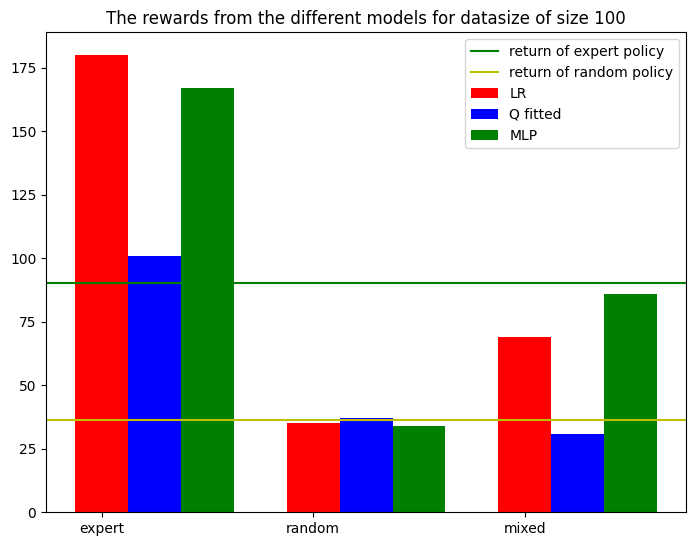

In [ ]:
L_R = [mean_100_expert_005_LR,mean_100_random_005_LR,mean_100_mixed_005_LR]
fitted = [mean_100_expert_005,mean_100_random_005,mean_100_mixed_005]
MLP = [mean_100_expert_005_MLP,mean_100_random_005_MLP,mean_100_mixed_005_MLP]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0, L_R, color ='r',label = "LR",width = 0.25)
ax.bar(X + 0.25, fitted, color ='b',label = "Q fitted",width = 0.25)
ax.bar(X + 0.5, MLP, color ='g',label = "MLP",width = 0.25)

ax.axhline(y = 90.28,color ='g',label = 'return of expert policy')
ax.axhline(y = 36.24,color ='y',label = 'return of random policy')
plt.legend()
plt.xticks(X,["expert", "random","mixed"])
plt.title("The rewards from the different models for datasize of size 100")


Text(0.5, 1.0, 'The Standard error reward from the different models datasize of size 100')

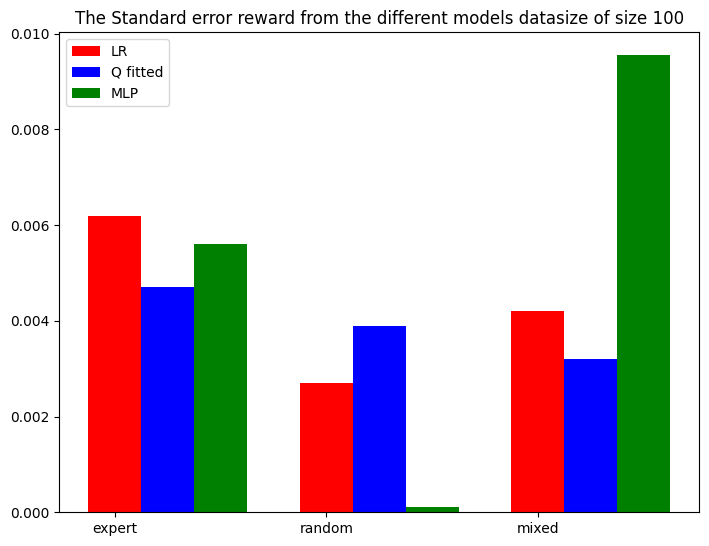

In [ ]:
L_R = [0.0062,0.0027,0.0042]
fitted = [0.0047,0.0039,0.0032]
MLP = [std_100_expert_005_MLP,std_100_random_005_MLP,std_100_mixed_005_MLP]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0, L_R, color ='r',label = "LR",width = 0.25)
ax.bar(X + 0.25, fitted, color ='b',label = "Q fitted",width = 0.25)
ax.bar(X + 0.5 , MLP, color = 'g', label = "MLP", width = 0.25)
# ax.axhline(y = 139.28,color ='g',label = 'return of expert policy')
# ax.axhline(y = 27.24,color ='y',label = 'return of random policy')
plt.xticks(X,["expert", "random","mixed"])
plt.legend()
plt.title("The Standard error reward from the different models datasize of size 100")

#**The Comments**

**The choice of the learning rate**

Here two alphas were tried out for Fitted Q learning (0.005 and 0.05) and the one kept for the graphs is the better performing one which is 0.005. Indeed the convergence of $\phi$ to the argmin is quite slow.

**The choice of $\gamma$ :**

Here the gamma that is used for the different expirements is the same as the one used for the expert policy, meaning $\gamma = 0.99$

**Stoping the training**

1. The training is stopped when the loss reaches a null value, so that we could avoid any potential overfitting, that would make the model completly dependant on the training dataset, and hence random in what comes to new data.

2. The parameter K for the **fitted Q Learning** Algorithm is relatively low K = 15, this can be due to the fact that we only have two actions and the gradient descent can very rapidly reach approximatively a null loss. In fact, when we see the steps 2 - 3 from the given algorithm in the assignement, we can observe that the update of $\phi$ is brings very "agressively" the value of Q to the desired target.


3. The parameter K for the **LR** or the **MLP** models is around 50, somtimes a 100. This makes sense since the learning rate that was taken is quite low, and since we can assume that we have a convex function (which is later confirmed by the performance of the testing). Indeed, when we take a larger learning_rate we can have explosing losses, since the approxiamtor leaves the minimum area and reaches high values in the loss function.


**Comapring the different models**

1. First thing to notice here, is how well the LR is performing, in almost all the cases, he outperforms the MLP and really outperforms the Fitted Q Learning.

    1.1. Indeed, the LR performs because the task at hand can be considered as a classification task. And here we have a classification of two labels (actions being either 0 or 1),So the LR is much more efficient in a classification than the Fitted Q LEarning or the MLP (which a slight variation of the Fitted Q Learning)

    1.2. Also one reason for which the LR learns really well is the size of the dataset (either being 500 ep, 250 ep or 100 ep). One has to keep in mind that each episode gives around few hundreds of pairs (state,action). And since the action can take (10000) values (due the one_hot_encoding, then LR basically sees every possible pair (state, action) which explains the reason for which it performs really well. But in a more complex RL problem maybe the offline LR approach wouldn't be as efficient.

2. In what comes to the comparison between MLP and Fitted Q Learning, since Fitted Q LEarning is one way approxiamtion to find the $\phi$ that minimzes the loss, it is quite logical that the MLP would outperform hand written first degree Taylor approxiamtion of the derivative of the loss.





**Comparing the different datasets**

**By size** : Quite logical that the best performing one is the 500 episodes since we have more data to train on which allows the model to be more performing.


**By quality** : For Fitted Q Learning and MLP , we can easily ibserve that the best performance is given for the expert data, and the worst one being the random one. The mixed dataset is in between. This makes sense, since the Q fitted leaning and MLP is really affected by the number of "accurate" samples in the dataset.

The difference with LR is that LR performs in mixed dataset almost as well as the expert one. In fact, even for only 100 episodes ,50 episodes from expert can give almost 6000-9000 pairs of "accurate" pairs.and we only have (1000*2) possible pairs overall.  Hence, the model has enough data to be performing well . and the few thousands pairs that are added from the random policy can be considered as just noise that disturbs the model.





**Comparing with the policies**

The LR and MLP usually outperfrom the expert policy when trained on the expert or the mixed datasets. Which as explained above is logical.

  1. LR has quite a lot of pairs to train on.
  2. The minimization of $\phi$ is far less efficient that a NN to predict Q. (MLP > Q fitted)